---
# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [8]:
""" Imports """
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob


In [9]:
class Points:
    """ Static class """
    objpoints = []
    imgpoints = []


In [10]:
def find_corner_coordinates_and_map_to_reference_chessboard():
    """
    Create 9 col x 6 row grid reference coordinates aka 3D objpoints.
    Locate corners surrounded by 4 squares in calibration images and store coordinates aka 2D imgpoints
    """
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    images = glob.glob('camera_cal/calibration*.jpg')
    for img in images:
        img = cv2.imread(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret:
            Points.imgpoints.append(corners)
            Points.objpoints.append(objp)
    print("Grid setup done.")


In [11]:
def calculate_camera_distortion_coefficients(img, objpts, imgpts):
    """
    aka calibrate camera
    :param img: to calculate against
    :param objpts: 3D grid coordinates from Points class
    :param imgpts: 2D image corner coordinates from Points class
    :return: ret [True | False], coefficients
    """
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
    print("Distortion coefficients calculated.")
    return mtx, dist


In [12]:
def undistort_calibration_image(img, mtx, dist):
    """
    Undistort the calibration image.
    :param img: calibration image
    :param mtx: calibration coefficient
    :param dist: calibration coefficient
    :return: undistorted calibration image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    print("Image undistorted.")
    return undist


In [13]:
def visual_comparison_of_distorted_undistorted_calibration_images(img1, img2, title1, title2, cmap):
    """

    :param img1: calibration image
    :param img2: undistorted calibration image
    :param title1: Distorted
    :param title2: Undistorted
    :param cmap: grayscale, else handle colour
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.set_title(title2, fontsize=50)
    if cmap=='gray':
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2)
        ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    print("Side-by-side view done.")


### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Grid setup done.
Distortion coefficients calculated.
Image undistorted.
Side-by-side view done.


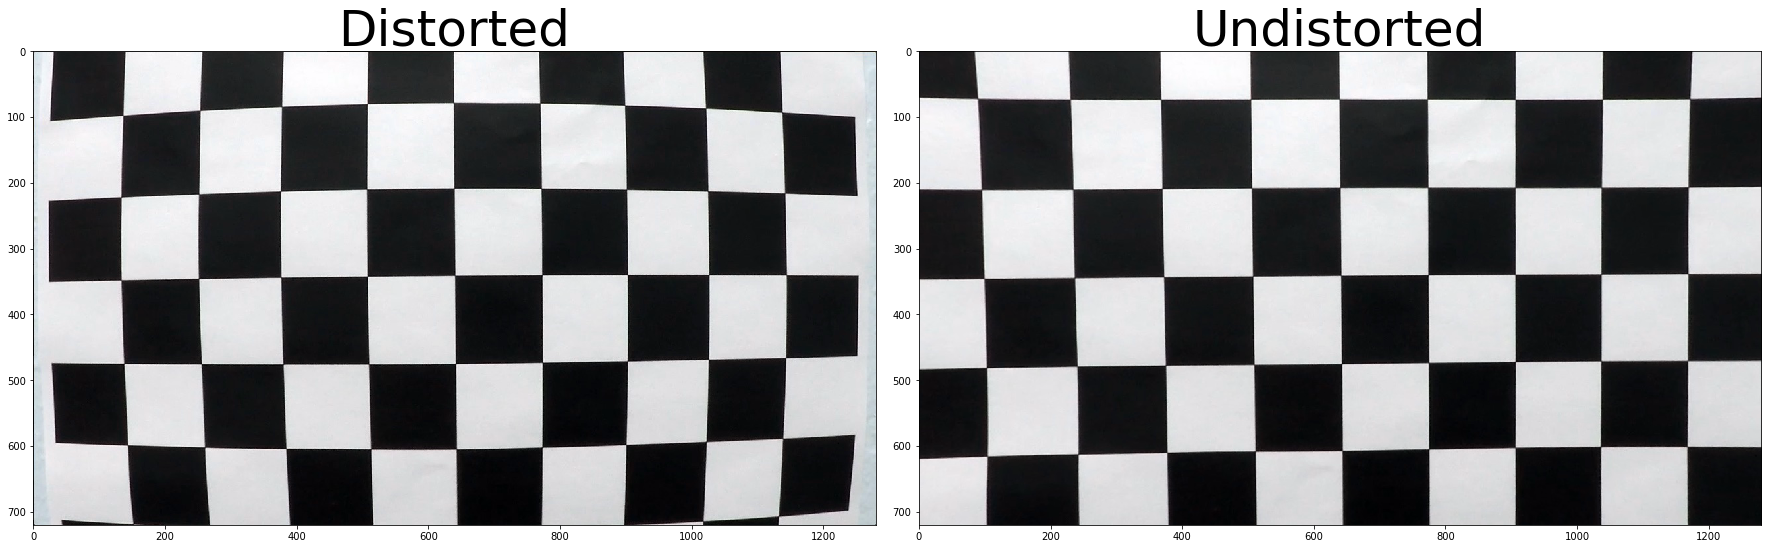

In [14]:
find_corner_coordinates_and_map_to_reference_chessboard()

calibration_img = cv2.imread("camera_cal/calibration1.jpg")
mtx, dist = calculate_camera_distortion_coefficients(calibration_img, Points.objpoints, Points.imgpoints)

undistorted_calibration_img = undistort_calibration_image(calibration_img, mtx, dist)
cv2.imwrite('camera_cal/undist_calibration1.jpg', undistorted_calibration_img)

visual_comparison_of_distorted_undistorted_calibration_images(calibration_img, undistorted_calibration_img, "Distorted", "Undistorted", 'gray')



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

""" Structure """
import calibrated_camera as camera
import gradient_image
import hls_image
import lane_lines

In [2]:
display = True

# TODO 2. Iterate over each frame in the video, applying all steps below until detect lane lines
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    test_img = cv2.imread(fname)
    if display:
        cv2.imshow('test_img', test_img)
        cv2.waitKey(1000)
        cv2.destroyAllWindows()
    # video_frame = ""
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    """ Computer Vision Setup """
    # 1. Calibrate Camera and Correct Distortion

    # points = camera.Points()
    # points.map_3d_object_to_2d_image_points(store=False, display=False)  # To test, set params (store=False, display=True)
    # print("points.imgpoints : ", points.imgpoints)  # 9x6 = 54 x,y coordinate lists per image array.
    undistorted_img = camera.calibrate_and_undistort(test_img, show_undistored_img=False)

    # Step through the list and apply colour and gradient thresholds

    # TODO 3. Colour and Gradient Thresholds
    # ------------------
    # 3.1 Apply colour threshold
    # filter_thresh = (0, 255)  # Colour intensity filter aka NO FILTER. Result == all black image returned. List of 1's
    filter_thresh = (90, 255)  # Colour intensity filter. Result == all black image returned. List start all 1's, ends all 0's
    # filter_thresh = (100, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (110, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (120, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (125, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (128, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (129, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (130, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (140, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (160, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (168, 255)  # Colour intensity filter. Result == all black image returned
    # filter_thresh = (170, 255)  # Colour intensity filter. Result == all black image returned. List starts all 0's, ends all 0's

    # test_img = hls_image.IntenseColoursMask.TEST_IMAGE  # Test image.
    hls_image.IntenseColoursMask.view_hls_binary_mask(undistorted_img, filter_thresh)  # TODO toggle comment
    # print(video_frame)
    # intense_colours_mask = hls_image.IntenseColoursMask.hls_select(undistorted_img, filter_thresh)  # TODO uncomment

    # Visual test
    # hls_image.IntenseColoursMask.view_hls_test()
    # hls_image.IntenseColoursMask.view_hls_binary_mask(undistorted_img, filter_thresh)  # TODO toggle comment
    # ------------------
    # 3.2. Generate gradient direction binary mask
    sobel_kernel_size = 15
    # threshold = (0.7, 1.3)  # note : default absolute radians filter is pi/2 (aka 90-degrees)
    threshold = (0, np.pi / 2)  # default

    # test_img = gradient_image.GradientBinaryMask.TEST_IMAGE  # Test image
    # direction_binary_mask = gradient_image.GradientBinaryMask.dir_threshold(undistorted_img, sobel_kernel_size, threshold)  # TODO uncomment

    # Visual test
    # gradient_image.GradientBinaryMask.view_mask_test(undistorted_img, sobel_kernel_size, threshold)  # TODO toggle comment
    # ------------------

    # TODO 4. Transform Perspective


    """ Find Real Lane Lines : Base Measurement """
    # TODO 5. Detect Lane Lines


    # TODO 6. Determine Lane Curvature
    # TODO TEST : Automatically determining if your detected lines are the real thing :
    # TODO 6.1. Check curvature : that both left and right lines have similar curvature.
    # TODO 6.2. Check separation : that they are separated by approx the correct distance horizontally
    # TODO 6.3. Check parallel : that they are roughly parallel.
    # TODO 6.4. Finding your offset from lane centre : assume camera is mounted at centre of car, so lane centre is at midpoint at bottom of image.


    # TODO Keeping track of recent measurements : instantiate lane_lines.Line for both left and right lane lines to keep track of recent values from previously processed images.


    """ Find Real Lane Lines : Next Measurement """
    # TODO 7. search within a window around the previous detection, then perform TEST
    """
    After determining you found the lines, where to look in the next frame :
    simply search within a window around the previous detection

    For example, if you fit a polynomial (WARN : I'd like to apply finding_the_lines_convolution.py instead!!!), then
    for each y position, you have an x position that represents the lane center from the last frame.
    Search for the new line within +/- some margin around the old line center.
    See finding_the_lines.py, Step 5 for details.

    Then do automatic test if detected lines are real aka check curvature, separation, parallel.
    """

    """
    If you lose track of the lines : assume just a bad image for 3-5 consecutive frames and use previous positions from
    last good frame.

    Else, go back to the blind search method using a histogram and sliding window, or other method,
    to re-establish your measurement.

    """

    """
    Smoothing (average) your measurements over last n frames.

    """

    """
    Drawing the line back down onto the road

    Once you have a good measurement of the line positions in warped space,
    it's time to project your measurement back down onto the road!

    Let's suppose, as in the previous example, you have a warped binary image called warped, and
    you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which
    represent the x and y pixel values of the lines.
    You can then project those lines onto the original image as follows:
    """
    # # Create an image to draw the lines on
    # warp_zero = np.zeros_like(warped).astype(np.uint8)
    # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #
    # # Recast the x and y points into usable format for cv2.fillPoly()
    # pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    # pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    # pts = np.hstack((pts_left, pts_right))
    #
    # # Draw the lane onto the warped blank image
    # cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #
    # # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # # Combine the result with the original image
    # result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # plt.imshow(result)



[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


KeyboardInterrupt: 